<a href="https://colab.research.google.com/github/Jucicarla/APE/blob/main/aula4_APE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aula sobre Exploração de dados**

Insight são informações e/ou conhecimento que existem nos dados


In [16]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [17]:
con = sqlite3.connect('/content/drive/MyDrive/northwind_small.sqlite')

Objetivo: 
  - Descobrir quais grupos de clientes mais contribuiram para os resultados financeiros da Northwindo
  - Questão do negocio: A receita média por pedido varia entre clientes de diferentes regiões 

Declarando as hipóteses:

    • Ho (Hipótese nula): o valor médio gasto por pedido é o mesmo entre as diferentes regiões do cliente.
    • H1 (Hipótese alternativa): o valor médio gasto por pedido é diferente (maior ou menor) entre as diferentes regiões do cliente
    • O nível alfa (ou seja, a probabilidade de rejeitar a hipótese nula quando ela for verdadeira) foi definido em 0,05.
    • Vou comparar multimplas medias. Usando ANOVA

Precisava extrair: região do cliente, a
quantidade total de cada produto pedido,
o preço unitário e o nível de desconto para cada pedido.

In [18]:
str_query = ('SELECT c.Region, od.OrderId, od.Quantity,'
             'od.UnitPrice, od.Discount '
             'FROM Customer c '
             'JOIN [Order] o ON c.Id = o.CustomerId '
             'JOIN OrderDetail od ON od.OrderId = o.Id' )

In [19]:
df = pd.read_sql_query(str_query, con)

In [20]:
df.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


Solução: O que realmente precisa é a receita total por pedido, aplicando o desconto ao produto do preço unitário e da quantidade unitária

In [21]:
df['price_per_order'] = df.Quantity *df.UnitPrice *(1- df.Discount)
df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)
df = df.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()
df.drop('OrderId', axis=1, inplace=True)

In [22]:
df.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


Solução: Também poderia acessar aos dados diretamente usando um sentença SQL

In [23]:
str_query = ('SELECT Region, sum(price_per_order)'
             ' FROM (SELECT c.Region, od.OrderId, od.ProductId, od.Quantity,'
             ' od.UnitPrice, od.Discount,'
             ' od.Quantity * od.UnitPrice * (1 - od.Discount) price_per_order'
             ' FROM Customer c'
             ' JOIN [Order] o ON c.Id = o.CustomerId'
             ' JOIN OrderDetail od ON od.OrderId = o.Id)'
             ' GROUP BY Region, OrderId')

In [24]:
df2 = pd.read_sql_query(str_query, con)


In [25]:
df2.head()

,Region,sum(price_per_order)
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


Explorando os dados

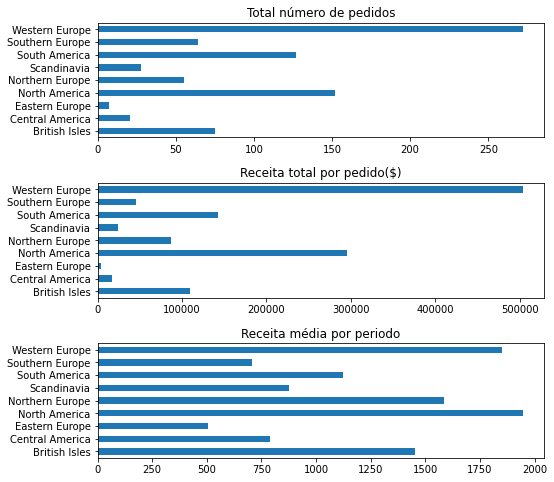

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8,8))
df.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
df.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total número de pedidos')
ax1.set_ylabel('')
ax2.set_title('Receita total por pedido($)')
ax2.set_ylabel('')
ax3.set_title('Receita média por periodo')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.4)

- H0:o valor médio gasto por pedido é o mesmo entre as diferentes regiões do cliente
- H1: o valor médio gasto por periodo é diferente entre as diferentes regiões do cliente

Teste de Hipóteses com ANOVA

- Para responde a pergunta se o valor médio gasto poer pedido varia entre clientes de diferentes regiões, foi usada ANOVA
- ANOVA(análise de Variança) avalia o grau de variação entre várias amostras. No exemplo cada amostr é região diferente neste caso
- ANOVA assume que:
    - os dados são normalmente distribuidos
    - as amostras têm variancias semelhantes


#Dados são normalmente distribuidos

Text(0, 0.5, '')

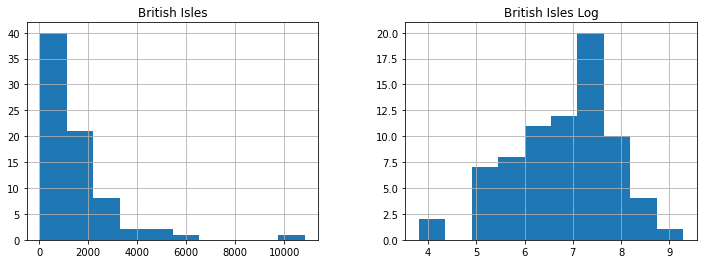

In [34]:
# verifica se a distribuição é normal, 
# se for assimétrica não pode usar ANOVA
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
df3_log[['Region', 'price_per_order']].loc[df3_log.loc[:,'Region']=='British Isles'].hist(ax=ax1)
df3_log[['Region', 'price_per_order2']].loc[df3_log.loc[:,'Region']=='British Isles'].hist(ax=ax2)
ax1.set_title('British Isles')
ax1.set_ylabel('')
ax2.set_title('British Isles Log')
ax2.set_ylabel('')


In [28]:
df3_log =  df.copy()

In [32]:
#transformação logarítmica: transforma os dados, usando logaritmo:
df3_log['price_per_order2'] = np.log(df['price_per_order'])


In [33]:
#transforma para distribuição normal, para usar ANOVA
df3_log

,Region,price_per_order,price_per_order2
0,British Isles,479.400,6.172535
1,British Isles,2645.000,7.880426
2,British Isles,1762.000,7.474205
3,British Isles,516.800,6.247656
4,British Isles,240.400,5.482304
...,...,...,...
796,Western Europe,86.850,4.464182
797,Western Europe,1629.975,7.396320
798,Western Europe,5218.000,8.559869
799,Western Europe,498.100,6.210801


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

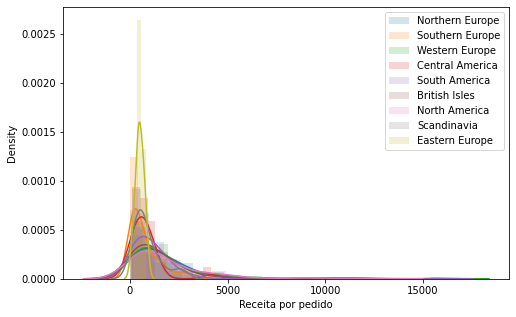

In [31]:
# normalmente distribuidos
# ploting the distributions
# gráfico 1 -dados normais
# gráfico 2 - dados usado o logaritmo

plt.figure(figsize=(8,5))
for region in set(df3_log.Region):
  region_group = df3_log.loc[df3_log['Region']==region]
  sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.2), label=region)
  plt.legend()
  plt.xlabel('Receita por pedido')

**Teste de Normalidade:**
Utilizados para verificar se a distribuição de probabilidade associada a um conjunto de dados pode ser aproximada pela distribuição normal

**Estatística Kolmogorov-Smirnov**(testa um conjunto de dados se aproxima da distribuição normal)  pode ser utilizado para avaliar as hipóteses:

  - H0: Os dados seguem uma distribuição normal
  - H1: os dados não seguem uma distribuição normal 

In [35]:
#kstest: kolmogorov
from scipy.stats import kstest, norm
my_data = df3_log['price_per_order'].loc[df3_log.loc[:,'Region']=='North America']
ks_statistic, p_value = kstest(my_data,'norm')
print(ks_statistic, p_value)
#

1.0 0.0


In [36]:
my_data = df3_log['price_per_order'].loc[df3_log.loc[:,'Region']=='British Isles']
ks_statistic, p_value = kstest(my_data,'norm')
print(ks_statistic, p_value)

1.0 0.0


As amostras têm variâncias semelhantes

In [37]:
df_var = df.groupby('Region')['price_per_order'].var().reset_index()

In [38]:
df_var

,Region,price_per_order
0,British Isles,2.620012e+06
1,Central America,7.226174e+05
2,Eastern Europe,4.504533e+04
3,North America,4.882239e+06
4,Northern Europe,3.011166e+06
5,Scandinavia,4.918731e+05
6,South America,2.312917e+06
7,Southern Europe,5.332121e+05
8,Western Europe,4.222322e+06


Teste ANOVA(usa média e variancia...)

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#ajustar um modelo de price_per_order em categorias de regiaõ
#e usar modelos de estatísticas para calcular uma tabela ANOVA

lm = ols('price_per_order ~ C(Region)', df3_log).fit()
sm.stats.anova_lm(lm, typ=2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,sum_sq,df,F,PR(>F)
C(Region),1.502147e+08,8.0,5.739638,4.009445e-07
Residual,2.590974e+09,792.0,NaN,NaN


 - Estatística de teste é a F = 5,74
 - df valores para a entrada na tabela de 8.0 e infinito = 1;94 rejeita H0
 - P-value = 4e-07, menos que alpha rejeita H0

In [ ]:
df3_log.head()

In [ ]:
#valores usando os dados de logaritimo
lm = ols('price_per_order2 ~ C(Region)', df3_log).fit()
sm.stats.anova_lm(lm, typ=2)

H0: o valor médio gasto por pedido é o mesmo entre as diferentes regiões do clientes.

H1: o valor médio gasto por pedido é diferente entre as diferentes regiões do cliente

**Conclusão:**

Existem diferentes estatisticamente significativas na receita média por pedido de clientes de diferentes regiões.